In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import glob
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
%load_ext autotime

time: 0 ns (started: 2024-07-04 15:57:13 +07:00)


In [3]:
%cd Dataset/time-of-day

D:\Kuliah\Mata Kuliah\Semester 4\Digital Image Processing\Project\Dataset\time-of-day
time: 0 ns (started: 2024-07-04 15:57:13 +07:00)


# Define Label and Store Image for Each Label

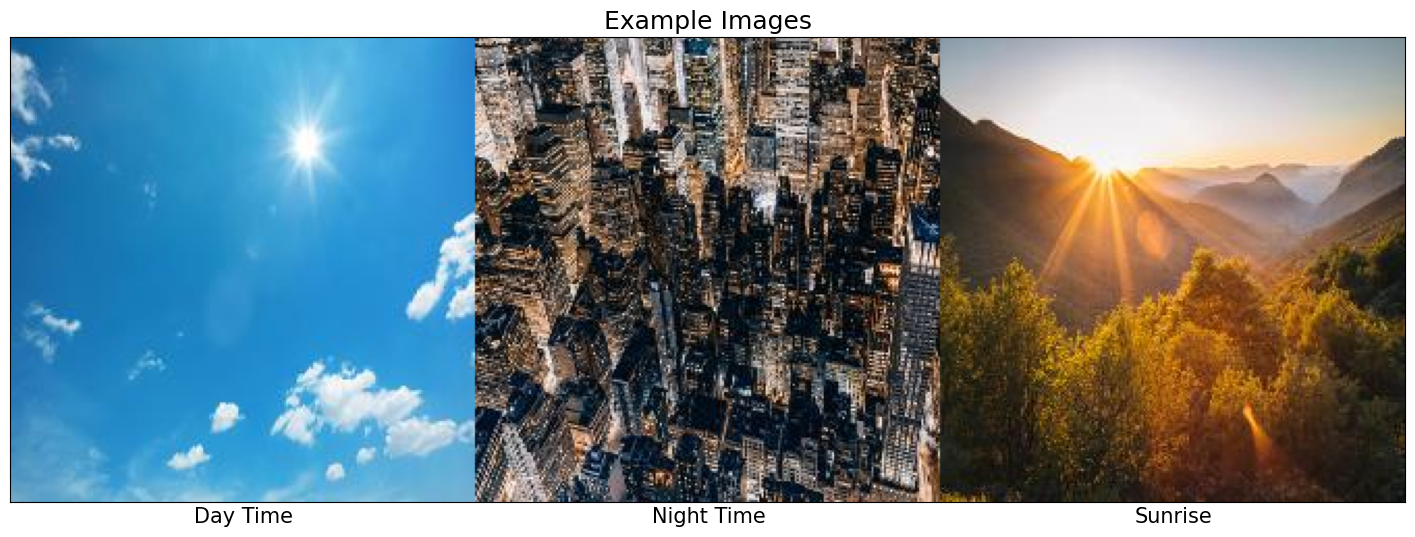

time: 485 ms (started: 2024-07-04 15:57:13 +07:00)


In [4]:
#from keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFont

daytime_img = Image.open("daytime/daylight_0.jpeg")
nighttime_img = Image.open("nighttime/Nighttime_0.jpeg")
sunrise_img = Image.open("sunrise/sunrise_0.jpeg")

example_imgs = [daytime_img, nighttime_img, sunrise_img]

w, h = example_imgs[1].size
grid = Image.new('RGBA', size=(3*w, h))
grid_w, grid_h = grid.size
ls = grid_w/3

for i, img in enumerate(example_imgs):
    grid.paste(img, box=(i%3*w, i//3*h))

plt.figure(figsize=(18, 10))
plt.title("Example Images", fontsize=18)
plt.imshow(grid)
plt.xticks([ls - ls/2, ls*2-ls/2, ls*3 - ls/2], ("Day Time", "Night Time", "Sunrise"), fontsize=15)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.yticks([])
plt.show()

In [5]:
dirs = os.listdir()

filename = []
labels = []  # Number between 0 and 5

for i in range(0, len(dirs)):
    os.chdir(dirs[i])
    files = os.listdir()  # Get List of file name in folder label
    for j in range(0, len(files)):
        files[j] = dirs[i] + "/" + files[j]  # Change Name of file
        labels.append(dirs[i])
    filename += files
    os.chdir(os.path.dirname(os.getcwd()))  # back to Initial Directory

time: 0 ns (started: 2024-07-04 15:57:13 +07:00)


In [6]:
# Save Image List to Dataframe
data = pd.DataFrame({
    "filename": filename,
    'label': labels
})

dataset = data.sample(frac=1)  # Shuffle data
dataset

,filename,label
903,nighttime/Nighttime_57.jpeg,nighttime
1047,sunrise/sunrise_197.jpeg,sunrise
1363,sunrise/sunrise_56.jpeg,sunrise
1246,sunrise/sunrise_392.jpeg,sunrise
138,daytime/daylight_24.jpeg,daytime
...,...,...
650,nighttime/Nighttime_28.jpeg,nighttime
666,nighttime/Nighttime_294.jpeg,nighttime
1154,sunrise/sunrise_300.jpeg,sunrise
929,nighttime/Nighttime_81.jpeg,nighttime


time: 16 ms (started: 2024-07-04 15:57:13 +07:00)


# Preprocessing

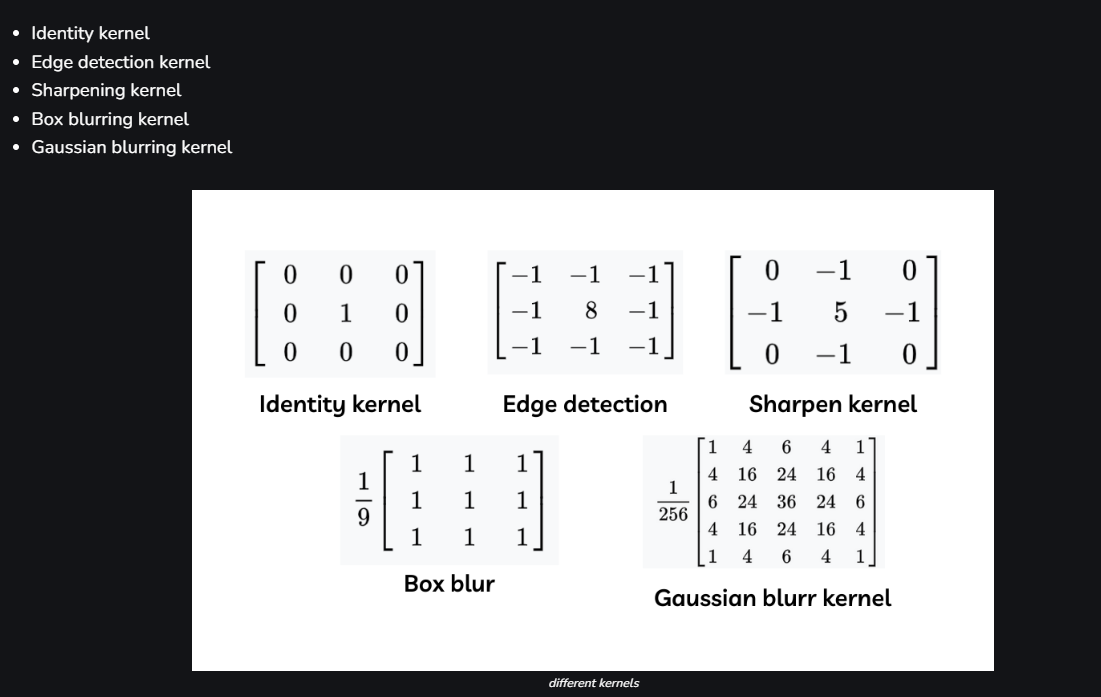

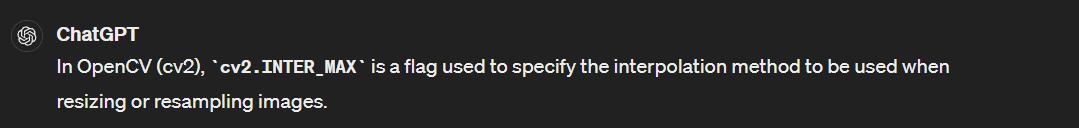

In [7]:
from keras.api.preprocessing.image import img_to_array

time: 3.83 s (started: 2024-05-19 19:55:26 +07:00)


In [7]:
def load_images(dataset):
    images = []
    Y = []

    for image in dataset.values:
        img = cv.cvtColor(cv.imread(image[0]), cv.COLOR_BGR2RGB)
        try:
            # Smoothing
            img = cv.GaussianBlur(img, (5, 5), 0)

            # Sharpening
            kernel = np.array([
                [0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]
            ])
            img = cv.filter2D(img, -1, kernel)

            # Resize
            img = cv.resize(img, (128, 128), interpolation=cv.INTER_AREA)
            # img = img_to_array(img)
            img = img / 255
        except:
            continue

        # Ubah jadi 1 dimensi vektor
        img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
        images.append(img)
        Y.append(image[1])
    X = np.array(images)
    Y = np.array(Y)
    return X, Y
    

time: 0 ns (started: 2024-07-04 15:57:13 +07:00)


In [8]:
from sklearn.model_selection import train_test_split

X, y = load_images(dataset)
print("data shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

data shape: (1407, 49152)
X_train:  (984, 49152)
y_train:  (984,)
X_test:  (423, 49152)
y_test:  (423,)
time: 8.84 s (started: 2024-07-04 15:57:13 +07:00)


# Classification

## Support Vector Machine (SVM)

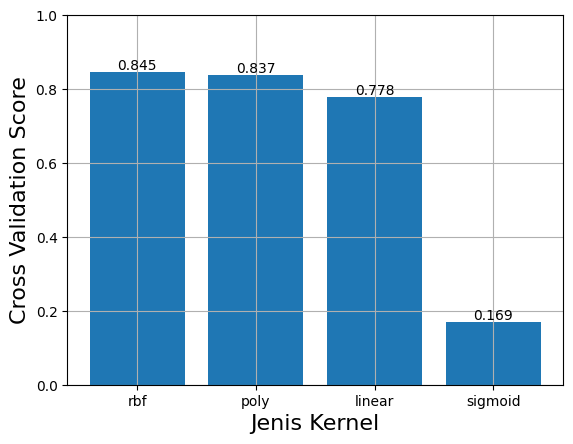

time: 10min 52s (started: 2024-07-04 13:02:36 +07:00)


In [10]:
from sklearn.svm import SVC
# classifier = SVC(kernel='rbf')  # 0.668
kernels = ['rbf', 'poly', 'linear', 'sigmoid']
scores = []

for kernel in kernels:
    classifier = SVC(kernel=kernel)
    score = cross_val_score(classifier, X, y, cv=5).mean()
    scores.append(round(score, 3))

plt.bar(kernels, scores)

for i in range(len(kernels)):
    plt.text(i, scores[i], scores[i], ha="center", va="bottom")
    
plt.ylabel("Cross Validation Score", fontsize=16)
plt.xlabel("Jenis Kernel", fontsize=16)

plt.ylim(0, 1)
plt.grid(True)
plt.show()

## KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
metrics = ['manhattan', 'euclidean', 'minkowski', 'chebyshev']
scores = {
    "neighbors": [],
    'metrics': [],
    "scores": []
}

for neighbor in neighbors:
    for metric in metrics:
        classifier = KNeighborsClassifier(n_neighbors=neighbor, weights='distance', metric=metric)
        score = cross_val_score(classifier, X, y, cv=5).mean()
        scores["neighbors"].append(neighbor)
        scores["metrics"].append(metric)
        scores["scores"].append(score)

df = pd.DataFrame(scores)
df

,neighbors,metrics,scores
0,3,manhattan,0.810222
1,3,euclidean,0.813074
2,3,minkowski,0.813074
3,3,chebyshev,0.503867
4,5,manhattan,0.815908
5,5,euclidean,0.809518
6,5,minkowski,0.809518
7,5,chebyshev,0.490361
8,7,manhattan,0.813081
9,7,euclidean,0.808808


time: 7min 37s (started: 2024-07-04 14:10:23 +07:00)


<Figure size 1000x600 with 0 Axes>

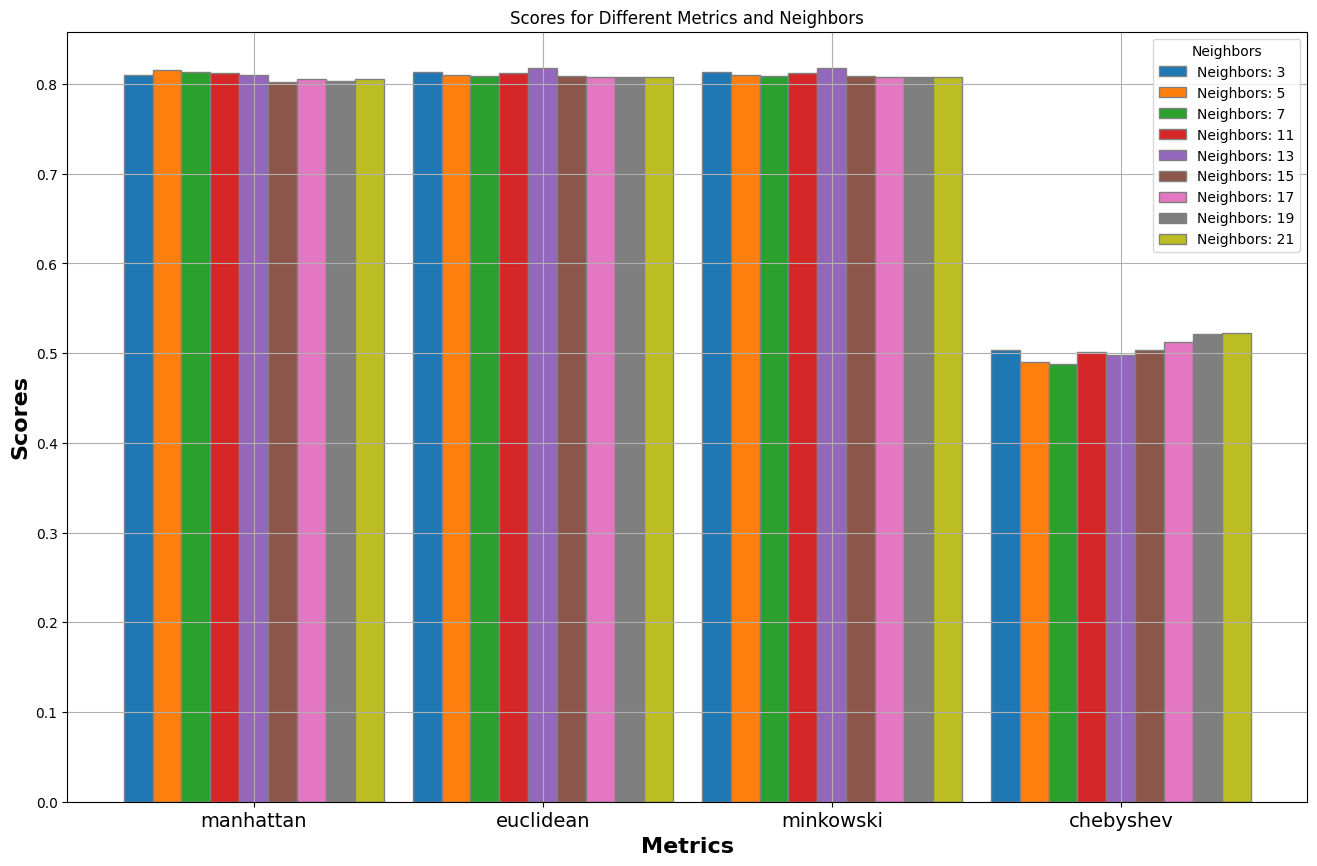

time: 265 ms (started: 2024-07-04 13:19:43 +07:00)


In [12]:
plt.figure(figsize=(10, 6))
neighbors = df['neighbors'].unique()
metrics = df['metrics'].unique()

bar_width = 0.1

r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]
r9 = [x + bar_width for x in r8]
rs = [r1, r2, r3, r4, r5, r6, r7, r8, r9]


plt.figure(figsize=(16, 10))

for i, neighbor in enumerate(neighbors):
    subset = df[df['neighbors'] == neighbor]
    # plt.bar(r1 if i == 0 else r2 if i == 1 else r3, subset['scores'], width=bar_width, edgecolor='grey', label=f'Neighbors: {neighbor}')
    plt.bar(rs[i], subset['scores'], width=bar_width, edgecolor='grey', label=f'Neighbors: {neighbor}')

# Add xticks on the middle of the group bars
plt.xlabel('Metrics', fontweight='bold', fontsize=16)
plt.ylabel('Scores', fontweight='bold', fontsize=16)
plt.xticks([r + (bar_width * (len(neighbors) // 2)) for r in range(len(metrics))], metrics, fontsize=14)

# Add a legend
plt.legend(title='Neighbors')

# Show the plot
plt.title("Scores for Different Metrics and Neighbors")
plt.grid(True)
plt.show()

# Confusion Matrix

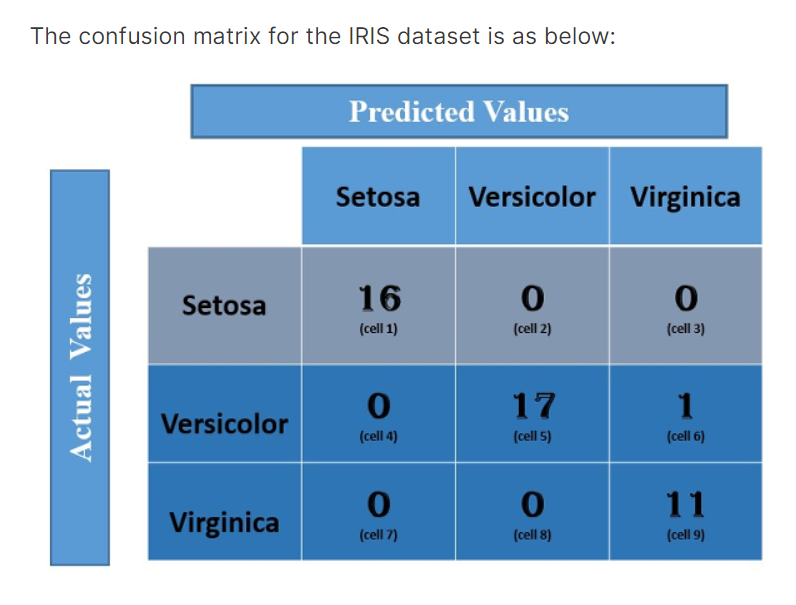

In [17]:
def extract_confusion_matrix_3d(confusion_matrix):
    # tp = np.diag(confusion_matrix).sum()
    # fn = confusion_matrix[0][1:].sum() + confusion_matrix[1][::2].sum() + confusion_matrix[2][:2].sum()
    # fp = confusion_matrix[1:, 0].sum() + confusion_matrix[::2, 1].sum() + confusion_matrix[:2, 2].sum()
    # tn = confusion_matrix[1:, 1:].sum() + confusion_matrix[::2, ::2].sum() + confusion_matrix[:2, :2].sum()

    tp = np.diag(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    # Sum the values for all classes
    tp = tp.sum()
    fp = fp.sum()
    fn = fn.sum()
    tn = tn.sum()
    return tp, fn, fp, tn

def get_performance(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = (tp) / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return acc, precision, recall, f1_score

time: 0 ns (started: 2024-07-04 16:00:05 +07:00)


## Support Vector Machine (SVM)

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
classifier_svm = SVC(kernel='rbf')
classifier_svm.fit(X_train, y_train)
y_pred = classifier_svm.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

confusion_matrix = confusion_matrix(y_pred, y_test)
print("\nConfusion Matrix:")
print(confusion_matrix)
print("")

Accuracy Score: 0.806146572104019

Confusion Matrix:
[[116  10  19]
 [ 16 116  13]
 [ 11  13 109]]

time: 41.1 s (started: 2024-07-04 15:59:02 +07:00)


In [27]:
# RUNTIME
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
classifier_svm = SVC(kernel='rbf')
classifier_svm.fit(X_train, y_train)
y_pred = classifier_svm.predict(X_test)

time: 50.1 s (started: 2024-07-04 14:59:03 +07:00)


In [16]:
tp, fn, fp, tn = extract_confusion_matrix_3d(confusion_matrix)
print(f"{tp}")
acc_svm, precision_svm, recall_svm, f1_score_svm = get_performance(tp, fn, fp, tn)

df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [acc_svm, precision_svm, recall_svm, f1_score_svm]
})

df

341


,Metric,Score
0,Accuracy,0.870764
1,Precision,0.806147
2,Recall,0.806147
3,F1 Score,0.806147


time: 15 ms (started: 2024-07-04 15:59:56 +07:00)


## KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

classifier_knn = KNeighborsClassifier(n_neighbors=13, weights='distance', metric='euclidean')
classifier_knn.fit(X_train, y_train)
y_pred = classifier_knn.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

confusion_matrix = confusion_matrix(y_pred, y_test)
print("\nConfusion Matrix:")
print(confusion_matrix)
print("")

Accuracy Score: 0.7872340425531915

Confusion Matrix:
[[ 92   6  13]
 [ 25 134  13]
 [ 23  10 107]]

time: 437 ms (started: 2024-07-04 14:57:20 +07:00)


In [28]:
# Runtime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

classifier_knn = KNeighborsClassifier(n_neighbors=13, weights='distance', metric='euclidean')
classifier_knn.fit(X_train, y_train)
y_pred = classifier_knn.predict(X_test)

time: 421 ms (started: 2024-07-04 14:59:53 +07:00)


In [21]:
tp, fn, fp, tn = extract_confusion_matrix_3d(confusion_matrix)
acc_knn, precision_knn, recall_knn, f1_score_knn = get_performance(tp, fn, fp, tn)

df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [acc_knn, precision_knn, recall_knn, f1_score_knn]
})

df

,Metric,Score
0,Accuracy,0.858156
1,Precision,0.787234
2,Recall,0.787234
3,F1 Score,0.787234


time: 0 ns (started: 2024-07-04 13:30:07 +07:00)


# Perbandingan Performa

In [22]:
df = pd.DataFrame({
    "Algoritma": ['SVM', 'KNN'],
    "Accuracy": [acc_svm, acc_knn],
    "Precision": [precision_svm, precision_knn],
    "Recall": [recall_svm, recall_knn],
    "F1 Score": [f1_score_svm, f1_score_knn]
})
df.set_index("Algoritma", inplace=True)
df

,Accuracy,Precision,Recall,F1 Score
Algoritma,,,,
SVM,0.878645,0.817967,0.817967,0.817967
KNN,0.858156,0.787234,0.787234,0.787234


time: 0 ns (started: 2024-07-04 13:30:14 +07:00)


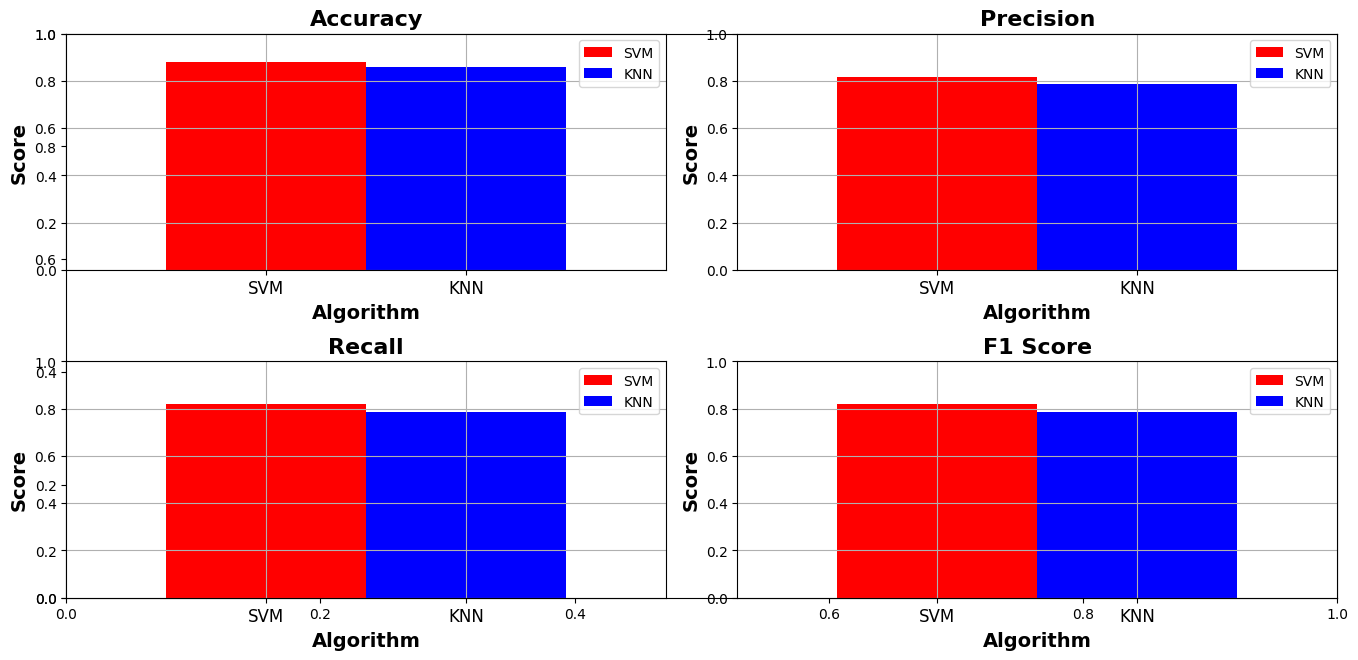

time: 719 ms (started: 2024-07-04 13:33:51 +07:00)


In [23]:
plt.subplots(figsize=(14, 7))
bar_width = 0.25

for i, col in enumerate(df.columns):
    plt.subplot(2, 2, i+1)
    plt.title(col, fontdict={'fontweight': 'bold', 'fontsize': 16})
    plt.bar([0, 0.25], [df[col]["SVM"], df[col]["KNN"]], width=bar_width, label=df.index.values, color=['red','blue'])
    plt.xlabel("Algorithm", fontweight='semibold', fontsize=14)
    plt.ylabel("Score", fontweight='semibold', fontsize=14)
    plt.ylim(0, 1)
    plt.xlim(-0.25, 0.5)
    plt.xticks([0, 0.25], ["SVM", "KNN"], fontsize=12)
    # plt.xticks([r + ])
    plt.tight_layout()
    plt.grid(True)
    plt.legend()

# Make Model File

In [22]:
import joblib

time: 0 ns (started: 2024-06-14 10:55:08 +07:00)


In [23]:
os.chdir("../..")

time: 0 ns (started: 2024-06-14 10:55:10 +07:00)


In [24]:
# Bikin folder "models" terlebih dahulu di satu folder yg sama dengan file ini

models = {
    "svm": classifier_svm, 
    "knn": classifier_knn
}
for algo, model in models.items():
    joblib.dump(model, f"models/{algo}_model.pkl")

time: 859 ms (started: 2024-06-14 10:55:24 +07:00)
